In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models
import numpy as np
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
import os
import json
from collections import defaultdict, Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, root_dir, target_size=(128, 128)):
        self.root_dir = Path(root_dir)
        self.target_size = target_size

        if not self.root_dir.exists():
            raise FileNotFoundError(f"{self.root_dir} не существует")

        self.class_folders = sorted(
            [d for d in self.root_dir.iterdir() if d.is_dir()]
        )
        if not self.class_folders:
            raise ValueError("Классы не найдены")

        self.class_names = [d.name for d in self.class_folders]
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}
        self.idx_to_class = {i: name for name, i in self.class_to_idx.items()}

        self.image_paths = []
        self.labels = []

        self._collect_data()

        print(f"Загружено {len(self.image_paths)} изображений")

    def _collect_data(self):
        exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}

        for class_name, class_idx in self.class_to_idx.items():
            folder = self.root_dir / class_name
            for img_path in folder.iterdir():
                if img_path.suffix.lower() in exts:
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        return img, label

    def get_class_name(self, label):
        return self.idx_to_class[label]
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label

In [3]:
from sklearn.model_selection import train_test_split

base_dataset = ImageDataset(
    root_dir="/kaggle/input/agrinet-128/Agrinet_128"
)

indices = np.arange(len(base_dataset))
labels = np.array(base_dataset.labels)

train_idx, temp_idx = train_test_split(
    indices,
    train_size=0.7,
    stratify=labels,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    train_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)
from torch.utils.data import Subset
train_transform = transforms.Compose([

    transforms.RandAugment(
        num_ops=2,   
        magnitude=9  
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_dataset = TransformDataset(
    Subset(base_dataset, train_idx),
    train_transform
)

val_dataset = TransformDataset(
    Subset(base_dataset, val_idx),
    val_transform
)

test_dataset = TransformDataset(
    Subset(base_dataset, test_idx),
    val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Загружено 29681 изображений


In [4]:
from torch import nn
class FinetuneModel(nn.Module):
    def __init__(self, backbone, feature_size, num_classes):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        features = self.backbone(x) 
        return self.classifier(features)

In [20]:
backbone = models.resnet50(weights=None)
feature_size = backbone.fc.in_features
backbone.fc = torch.nn.Identity()

backbone = backbone.to("cuda")


ckpt = torch.load("/kaggle/input/finetune/checkpoint_arginet_128_4_exp_different_Adam.pth")

state_dict = ckpt['model_state']

model = FinetuneModel(backbone = backbone, feature_size = 2048, num_classes = 65)

model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

In [8]:
import torch
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def evaluate_model(model, loader, num_classes):
    model.eval()
    correct = 0
    total = 0

    per_class_correct = np.zeros(num_classes, dtype=np.int64)
    per_class_total = np.zeros(num_classes, dtype=np.int64)

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        for c in range(num_classes):
            mask = (labels == c)
            per_class_total[c] += mask.sum().item()
            per_class_correct[c] += (preds[mask] == labels[mask]).sum().item()

    overall_acc = correct / total
    per_class_acc = per_class_correct / np.maximum(per_class_total, 1)

    return overall_acc, per_class_acc, per_class_total


In [23]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)


Test overall acc: 0.840556927913766
Per class acc: [0.96153846 0.88888889 0.90789474 0.96923077 0.63157895 0.79136691
 0.875      0.82608696 1.         0.93333333 0.73913043 0.90909091
 0.7173913  0.88235294 0.5625     0.74910394 0.26530612 0.24691358
 0.45454545 0.94791667 0.97297297 0.5        0.90909091 0.66666667
 0.82352941 0.9047619  0.83333333 0.70588235 1.         0.80701754
 0.89795918 0.95384615 0.50819672 0.87681159 0.97540984 0.89516129
 0.83333333 1.         0.92783505 0.87037037 0.86666667 1.
 0.82442748 0.89655172 0.88461538 1.         0.86111111 0.93103448
 0.53846154 0.92857143 0.75       0.8125     0.92592593 0.64705882
 0.98340249 0.73913043 0.8125     0.93975904 0.89285714 0.9
 0.81578947 0.25       0.91847826 0.87892377 0.86324786]
Per class test counts: [ 26  18  76  65  38 139  24  23  12  15  46  44  46 170 144 279  49  81
  33  96 111  12  11  18  17  21   6  34  27  57  49  65  61 138 122 124
  36  55  97  54  15  29 131 145  52 113  36  29  13  14   8  16  27

In [9]:
def compute_head_tail_stats(per_class_train_counts, per_class_acc, num_splits=3):
    counts = np.array(per_class_train_counts)
    idx = np.arange(len(counts))

    order = np.argsort(counts)  # от самых редких к самым частым
    split_sizes = np.array_split(order, num_splits)

    groups = {}
    for name, group_idx in zip(["tail", "medium", "head"], split_sizes):
        group_counts = counts[group_idx]
        group_acc = per_class_acc[group_idx]
        groups[name] = {
            "class_indices": group_idx,
            "mean_acc": float(np.mean(group_acc)),
            "mean_count": float(np.mean(group_counts)),
        }
    return groups


In [26]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 145.0952380952381 mean acc: 0.8457821370366904
medium mean count: 46.81818181818182 mean acc: 0.7948484432391104
tail mean count: 17.09090909090909 mean acc: 0.8061032450869117


In [10]:
import matplotlib.pyplot as plt

def plot_head_tail(groups, title=""):
    names = ["head", "medium", "tail"]
    vals = [groups[n]["mean_acc"] for n in names]

    plt.figure(figsize=(4, 4))
    plt.bar(names, vals)
    plt.ylim(0, 1)
    plt.ylabel("Mean per-class accuracy")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_size_vs_acc(per_class_train_counts, per_class_acc, title=""):
    plt.figure(figsize=(5, 4))
    plt.scatter(per_class_train_counts, per_class_acc, alpha=0.7)
    plt.xscale("log")
    plt.xlabel("Train samples per class (log scale)")
    plt.ylabel("Per-class accuracy")
    plt.title(title)
    plt.tight_layout()
    plt.show()



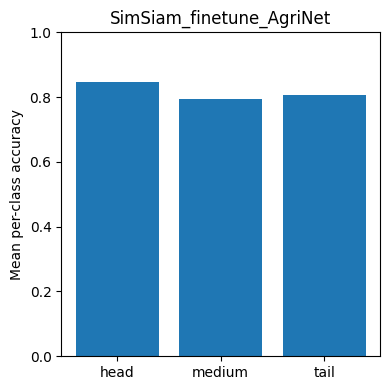

In [27]:
plot_head_tail(groups, title="SimSiam_finetune_AgriNet")


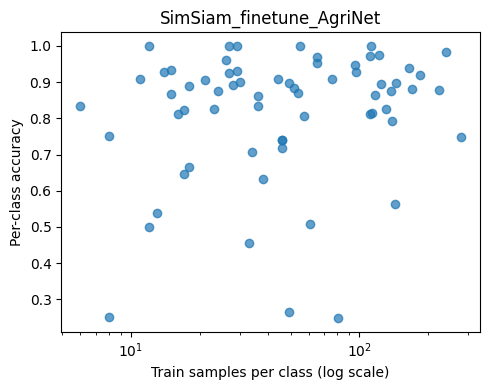

In [28]:
plot_size_vs_acc(per_class_test_counts, per_class_acc, title="SimSiam_finetune_AgriNet")


In [11]:
def plot_gaps(gaps, save_path=None):
    # gaps: список словарей из compute_gaps()
    labels = []
    vals = []
    for g in gaps:
        labels.append(f"{g['model_type']}_{g['protocol']}")
        vals.append(g["delta_rel"])

    x = np.arange(len(labels))
    plt.figure(figsize=(8, 4))
    plt.bar(x, vals)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Relative gap (Δ_rel)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


In [12]:
def plot_tsne(exp_name, max_samples=2000):
    res = RESULTS[exp_name]
    feats = res["metrics"]["features"].numpy()
    labels = res["metrics"]["labels"].numpy()

    # subsample для скорости
    if len(feats) > max_samples:
        idx = np.random.choice(len(feats), size=max_samples, replace=False)
        feats = feats[idx]
        labels = labels[idx]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca")
    emb_2d = tsne.fit_transform(feats)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                          c=labels, cmap="tab20", s=5, alpha=0.7)
    plt.xticks([])
    plt.yticks([])
    plt.title(exp_name)
    plt.tight_layout()
    plt.show()


In [13]:
@torch.no_grad()
def extract_features(backbone, loader):
    backbone.eval()
    all_feats = []
    all_labels = []
    for images, labels in loader:
        images = images.to(DEVICE)
        feats = backbone(images)
        all_feats.append(feats.cpu())
        all_labels.append(labels)
    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_feats, all_labels


In [32]:
features, labels = extract_features(backbone, test_loader)

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(features, labels, class_names=None, max_samples=2000, title="t-SNE"):
    feats = features.numpy()
    labs = labels.numpy()

    # subsample для скорости
    if len(feats) > max_samples:
        idx = np.random.choice(len(feats), size=max_samples, replace=False)
        feats = feats[idx]
        labs = labs[idx]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca", random_state=42)
    emb_2d = tsne.fit_transform(feats)

    plt.figure(figsize=(12, 12))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                          c=labs, cmap="tab20", s=5, alpha=0.7)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)


    plt.tight_layout()
    plt.show()


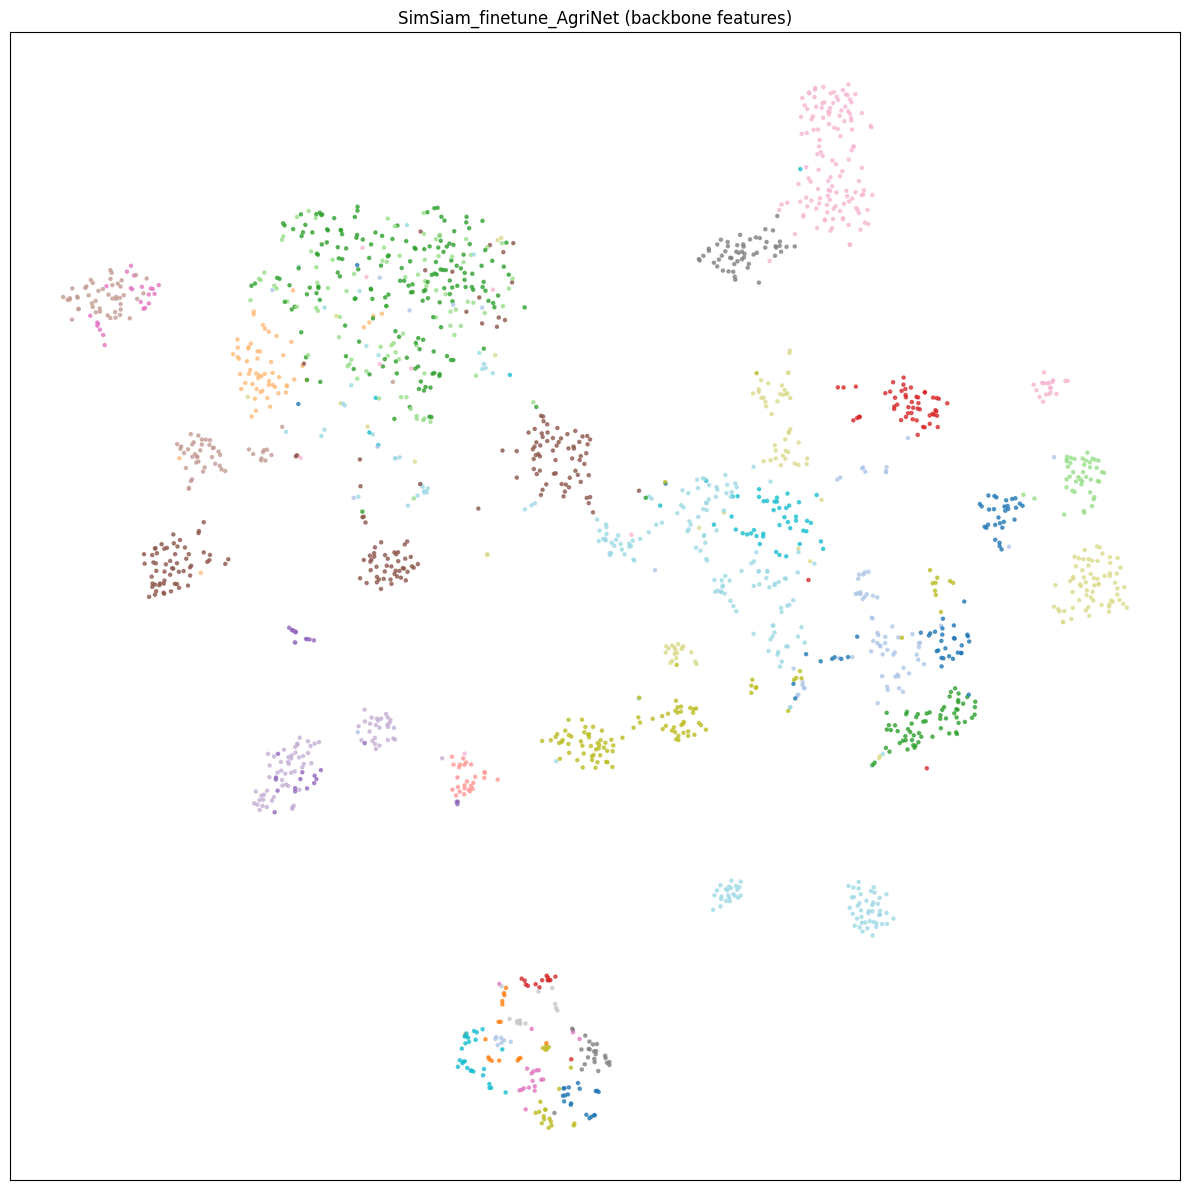

In [36]:
plot_tsne(features, labels, title="SimSiam_finetune_AgriNet (backbone features)")

In [7]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(2048, 65)
model = model.to("cuda")

ckpt = torch.load("/kaggle/input/supervisec/sl_imbalanced_agr_best.pth")


model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

In [15]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)

Test overall acc: 0.9189310577139007
Per class acc: [0.96153846 1.         0.96052632 0.93846154 0.84210526 0.88489209
 0.95833333 0.86956522 1.         0.93333333 0.84782609 0.93181818
 0.80434783 0.93529412 0.83333333 0.8781362  0.55102041 0.65432099
 0.63636364 0.9375     0.98198198 0.75       1.         0.88888889
 0.88235294 1.         1.         0.85294118 1.         0.98245614
 0.97959184 0.96923077 0.81967213 0.97101449 1.         0.94354839
 0.94444444 1.         0.91752577 0.96296296 1.         1.
 0.91603053 0.82758621 0.90384615 0.99115044 0.91666667 0.86206897
 0.92307692 0.92857143 0.875      0.6875     1.         1.
 0.99170124 0.93478261 0.89285714 0.95783133 0.96428571 0.96666667
 0.9122807  0.75       0.95652174 0.93721973 0.99145299]
Per class test counts: [ 26  18  76  65  38 139  24  23  12  15  46  44  46 170 144 279  49  81
  33  96 111  12  11  18  17  21   6  34  27  57  49  65  61 138 122 124
  36  55  97  54  15  29 131 145  52 113  36  29  13  14   8  16  27

In [16]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 145.0952380952381 mean acc: 0.9196275914613078
medium mean count: 46.81818181818182 mean acc: 0.8912636263423511
tail mean count: 17.09090909090909 mean acc: 0.9260202837089025


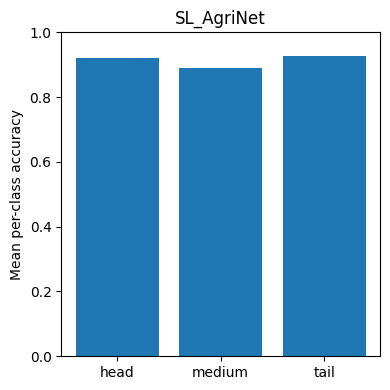

In [17]:
plot_head_tail(groups, title="SL_AgriNet")

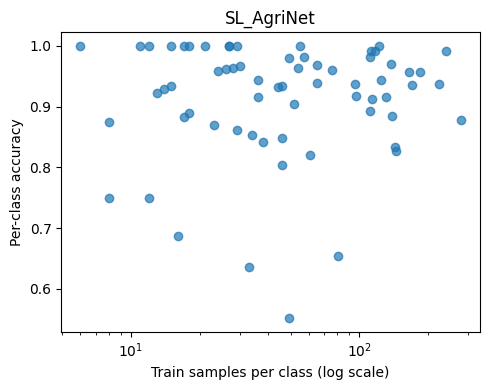

In [18]:
plot_size_vs_acc(per_class_test_counts, per_class_acc, title="SL_AgriNet")

In [19]:
features, labels = extract_features(model, test_loader)

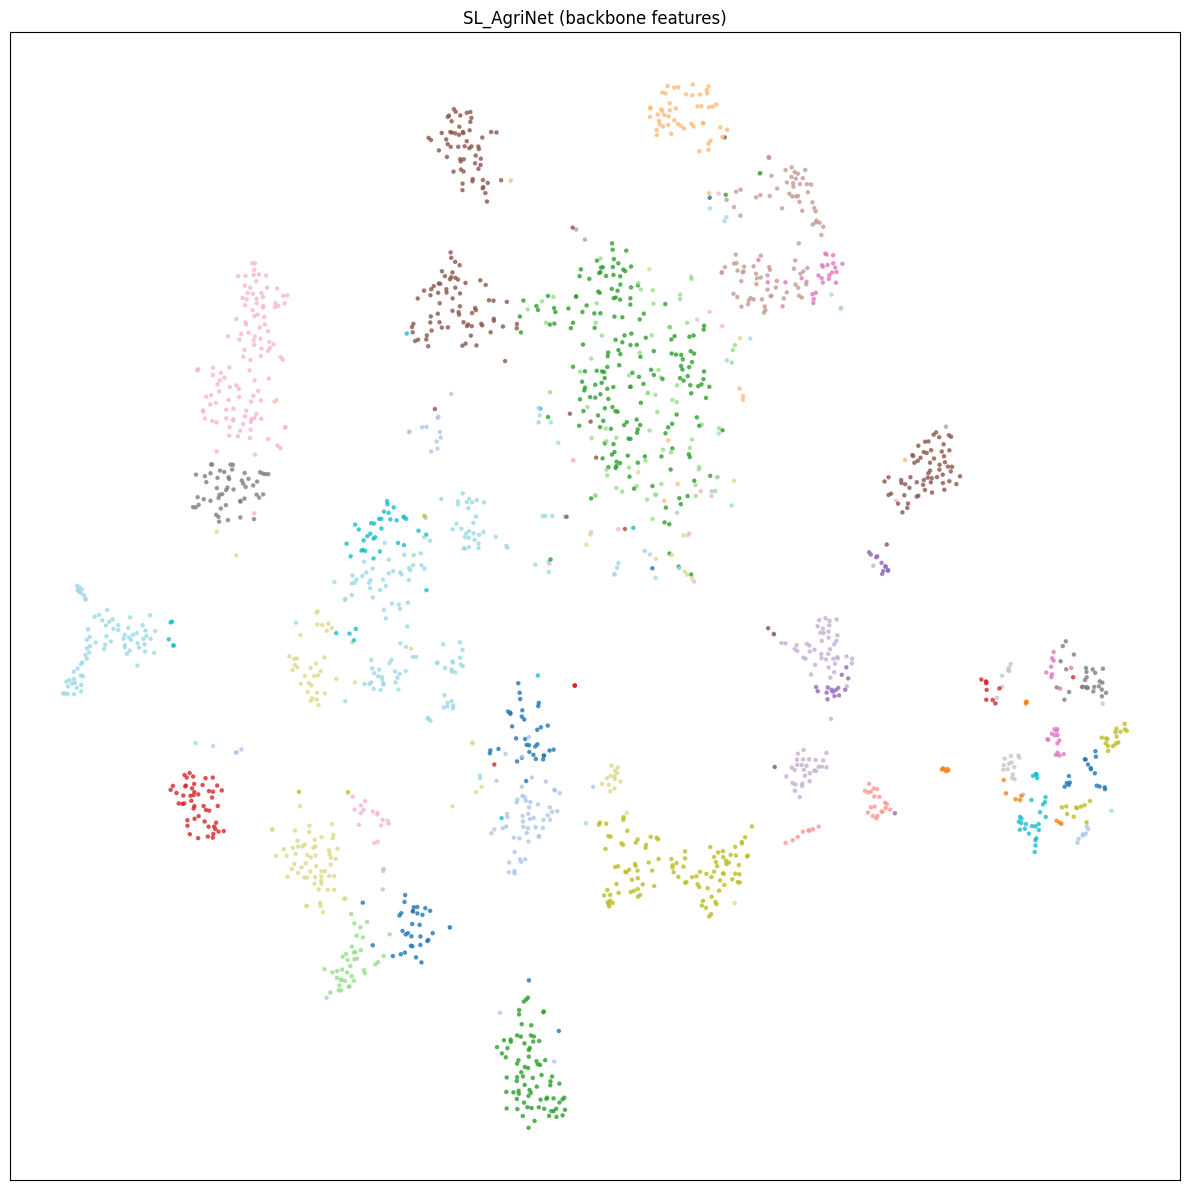

In [20]:
plot_tsne(features, labels, title="SL_AgriNet (backbone features)")

In [6]:
backbone = models.resnet50(weights=None)
feature_size = backbone.fc.in_features
backbone.fc = torch.nn.Identity()

backbone = backbone.to("cuda")


ckpt = torch.load("/kaggle/input/finetune-new/checkpoint_arignet_1_model_exp_1_final.pth")

# state_dict = ckpt['model_state']

model = FinetuneModel(backbone = backbone, feature_size = 2048, num_classes = 65)

model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

In [15]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)

Test overall acc: 0.8605434538513361
Per class acc: [1.         0.88888889 0.92105263 0.93846154 0.60526316 0.71223022
 0.79166667 0.91304348 1.         1.         0.82608696 0.93181818
 0.73913043 0.88823529 0.55555556 0.74910394 0.42857143 0.2962963
 0.36363636 0.89583333 1.         0.75       0.90909091 0.83333333
 0.94117647 0.95238095 1.         0.79411765 1.         0.94736842
 0.87755102 0.95384615 0.70491803 0.89130435 1.         0.92741935
 0.94444444 1.         0.94845361 0.81481481 1.         0.96551724
 0.92366412 0.84827586 0.80769231 0.92920354 0.77777778 0.93103448
 0.53846154 0.85714286 0.875      0.8125     0.96296296 0.94117647
 0.98755187 0.84782609 0.88392857 0.95783133 0.96428571 0.96666667
 0.9122807  0.25       0.90217391 0.91479821 0.93162393]
Per class test counts: [ 26  18  76  65  38 139  24  23  12  15  46  44  46 170 144 279  49  81
  33  96 111  12  11  18  17  21   6  34  27  57  49  65  61 138 122 124
  36  55  97  54  15  29 131 145  52 113  36  29  13 

In [16]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 145.0952380952381 mean acc: 0.8597982852082675
medium mean count: 46.81818181818182 mean acc: 0.822163445041303
tail mean count: 17.09090909090909 mean acc: 0.8718686473932347


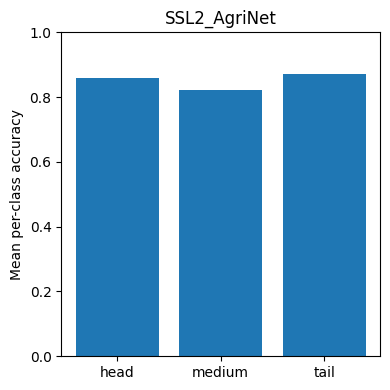

In [18]:
plot_head_tail(groups, title="SSL2_AgriNet")

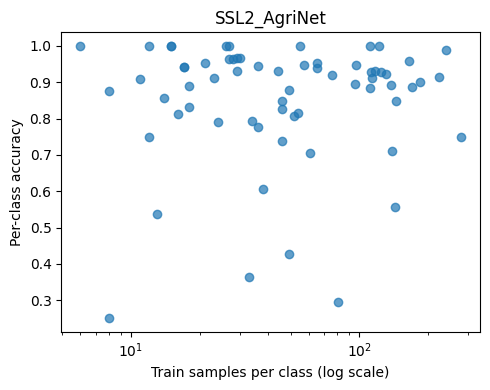

In [19]:
plot_size_vs_acc(per_class_test_counts, per_class_acc, title="SSL2_AgriNet")

In [20]:
features, labels = extract_features(model, test_loader)

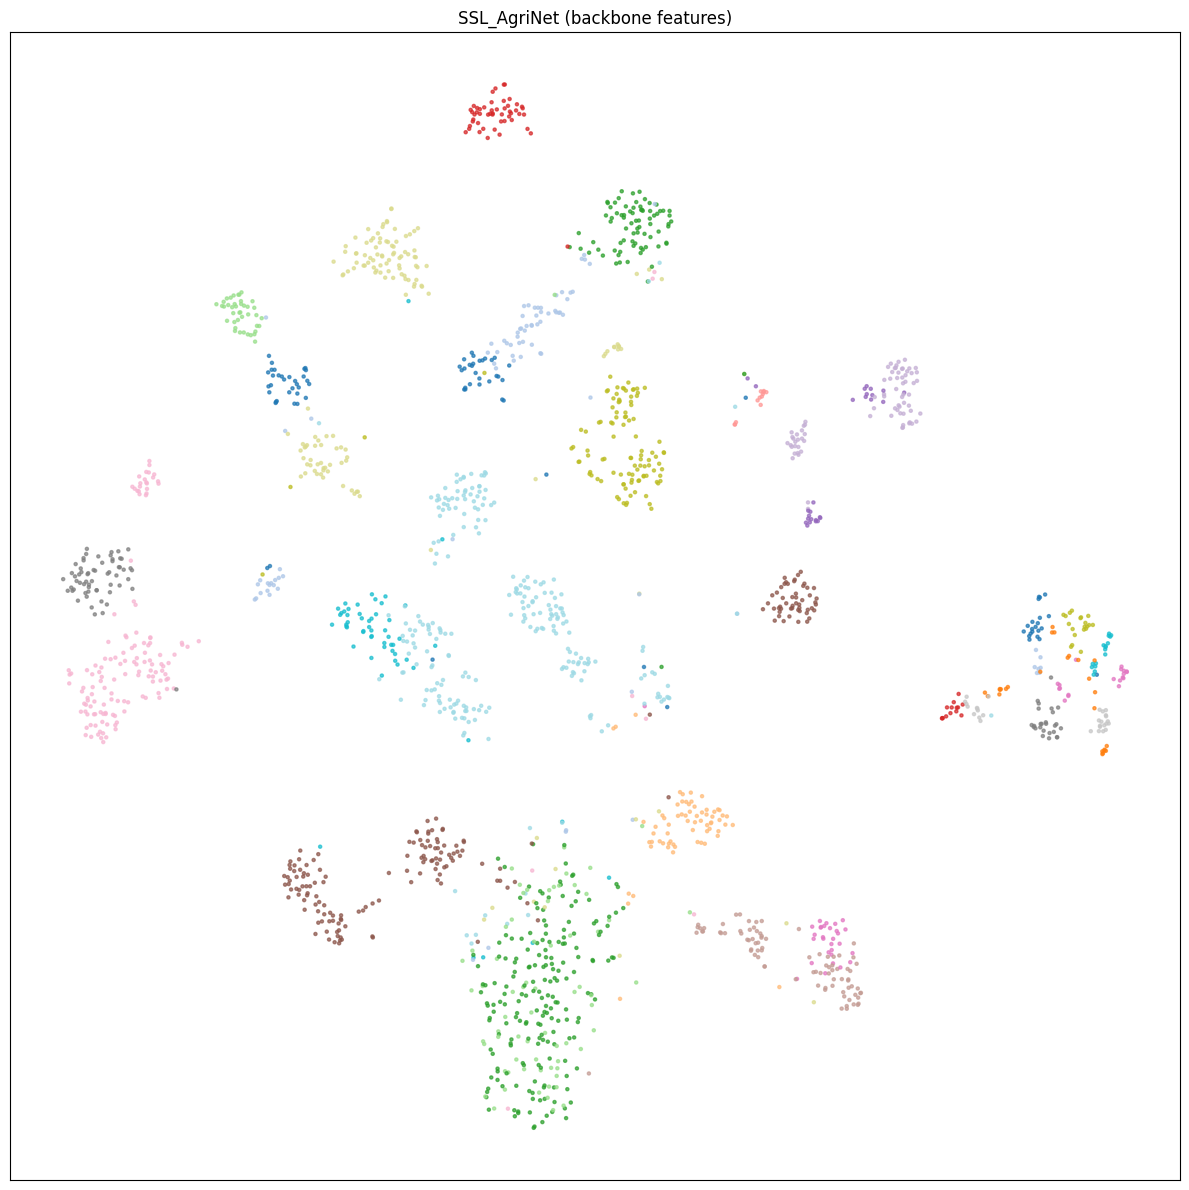

In [21]:
plot_tsne(features, labels, title="SSL_AgriNet (backbone features)")

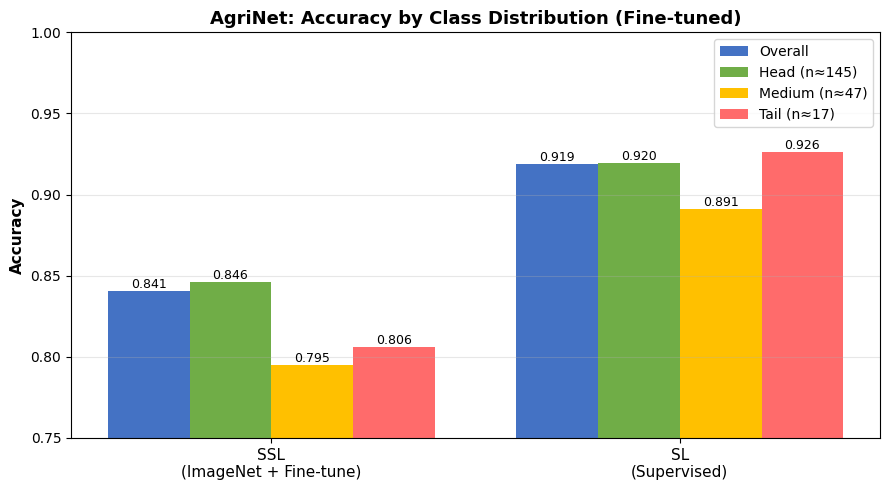

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Данные
methods = ["SSL\n(ImageNet + Fine-tune)", "SL\n(Supervised)"]
overall = [0.8406, 0.9189]
head = [0.8458, 0.9196]
medium = [0.7948, 0.8913]
tail = [0.8061, 0.9260]

x = np.arange(len(methods))
width = 0.2

fig, ax = plt.subplots(figsize=(9, 5))

bars1 = ax.bar(x - 1.5*width, overall, width, label="Overall", color="#4472C4")
bars2 = ax.bar(x - 0.5*width, head, width, label="Head (n≈145)", color="#70AD47")
bars3 = ax.bar(x + 0.5*width, medium, width, label="Medium (n≈47)", color="#FFC000")
bars4 = ax.bar(x + 1.5*width, tail, width, label="Tail (n≈17)", color="#FF6B6B")

ax.set_ylabel("Accuracy", fontsize=11, weight="bold")
ax.set_title("AgriNet: Accuracy by Class Distribution (Fine-tuned)", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=11)
ax.legend(fontsize=10)
ax.set_ylim(0.75, 1.0)
ax.grid(axis="y", alpha=0.3)

# Добавить значения на столбцы
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("barplot_ssl_vs_sl.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
backbone = models.resnet50(weights=None)
feature_size = backbone.fc.in_features
backbone.fc = torch.nn.Identity()

backbone = backbone.to("cuda")


ckpt = torch.load("/kaggle/input/finetune-new/checkpoint_awa_1_model_best_exp2.pth")

state_dict = ckpt['model_state'] 

model = FinetuneModel(backbone = backbone, feature_size = 2048, num_classes = 50)

model.load_state_dict(state_dict, strict=False)

In [24]:
from sklearn.model_selection import train_test_split

base_dataset = ImageDataset(
    root_dir="/kaggle/input/awa-128/AwA"
)

indices = np.arange(len(base_dataset))
labels = np.array(base_dataset.labels)

train_idx, temp_idx = train_test_split(
    indices,
    train_size=0.7,
    stratify=labels,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    train_size=0.5,
    stratify=labels[temp_idx],
    random_state=42
)
from torch.utils.data import Subset
train_transform = transforms.Compose([

    transforms.RandAugment(
        num_ops=2,   
        magnitude=9  
    ),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize(144),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


train_dataset = TransformDataset(
    Subset(base_dataset, train_idx),
    train_transform
)

val_dataset = TransformDataset(
    Subset(base_dataset, val_idx),
    val_transform
)

test_dataset = TransformDataset(
    Subset(base_dataset, test_idx),
    val_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

Загружено 37322 изображений


In [42]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)

Test overall acc: 0.3286301125200929
Per class acc: [0.52229299 0.01754386 0.         0.         0.03191489 0.38518519
 0.02352941 0.01834862 0.23376623 0.21393035 0.37804878 0.24752475
 0.76760563 0.63461538 0.01010101 0.11612903 0.67938931 0.41436464
 0.74045802 0.1328125  0.45299145 0.08823529 0.38866397 0.55140187
 0.02325581 0.39814815 0.60130719 0.         0.0754717  0.
 0.02631579 0.12844037 0.21428571 0.23364486 0.63846154 0.38650307
 0.02597403 0.         0.28571429 0.58108108 0.51173709 0.22666667
 0.         0.         0.32222222 0.35606061 0.         0.
 0.07954545 0.59090909]
Per class test counts: [157  57  29  26  94 135  85 109 154 201  82 202 142 156  99 155 131 181
 131 128 117 102 247 107  43 108 153  15 106  28 114 109 112 107 130 163
  77  46 105 148 213  75  28  43 180 132  32  41  88 176]


In [43]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 172.6875 mean acc: 0.43236486955805903
medium mean count: 114.52941176470588 mean acc: 0.2958988873828953
tail mean count: 52.294117647058826 mean acc: 0.04743993568578179


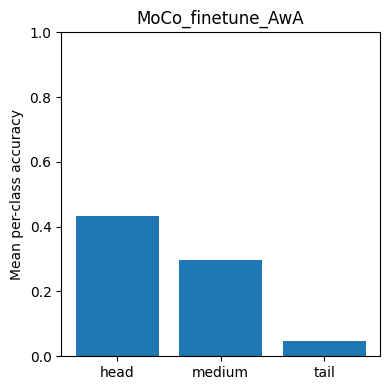

In [44]:
plot_head_tail(groups, title="MoCo_finetune_AwA")

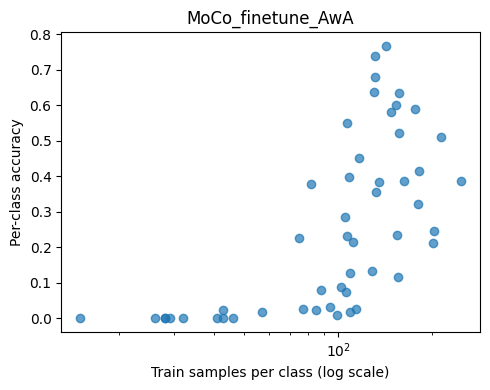

In [46]:
plot_size_vs_acc(per_class_test_counts, per_class_acc, title="MoCo_finetune_AwA")

In [47]:
features, labels = extract_features(backbone, test_loader)

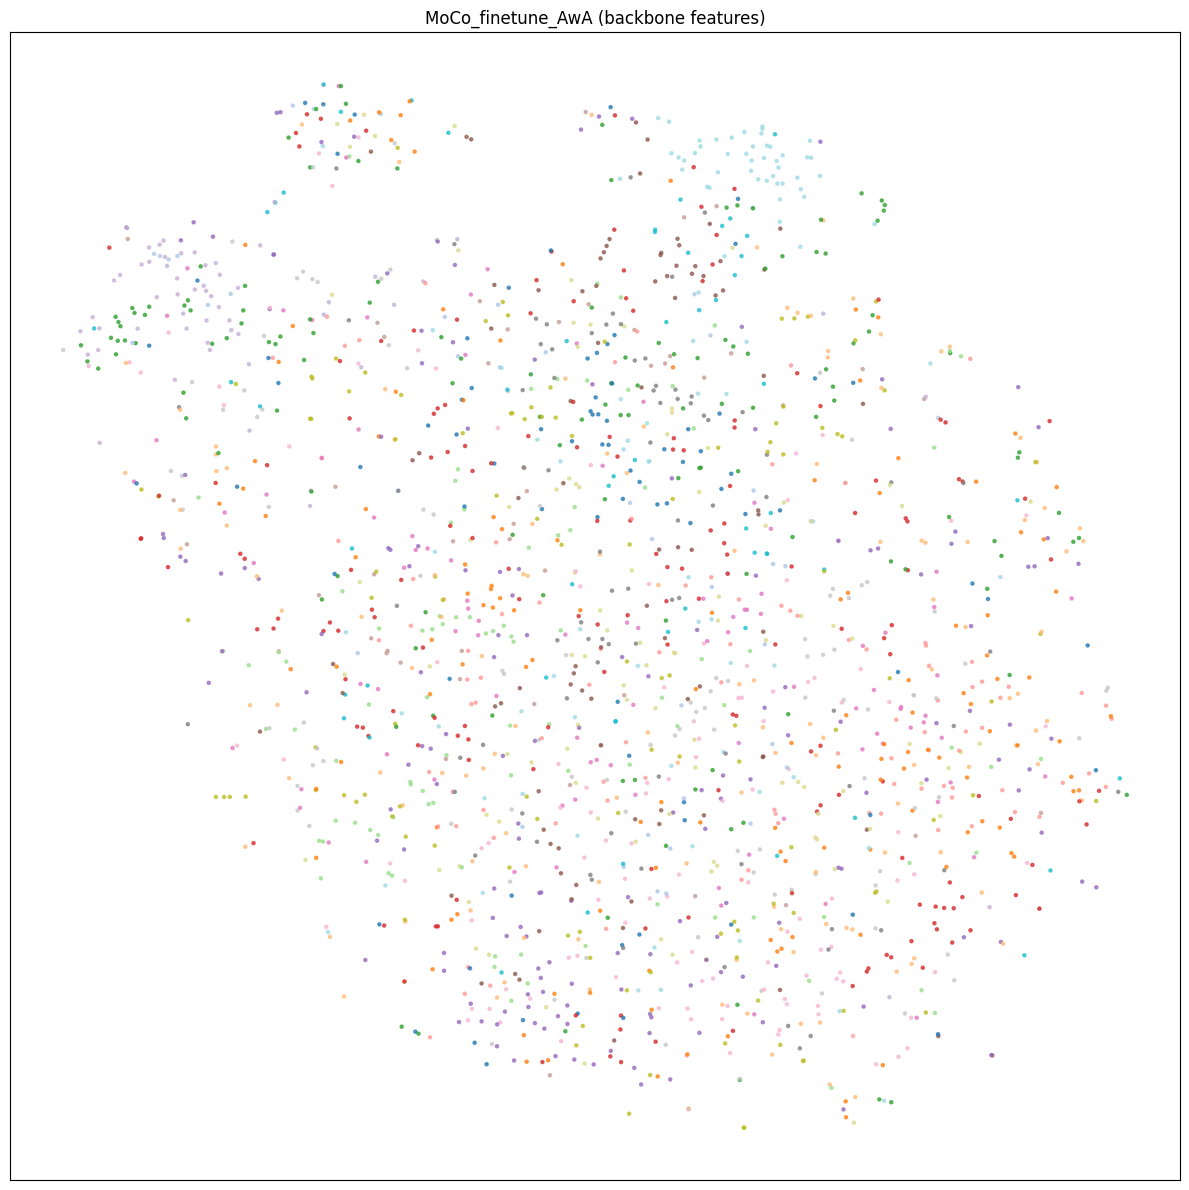

In [48]:
plot_tsne(features, labels, title="MoCo_finetune_AwA (backbone features)")

In [36]:
model = models.resnet50(weights=None)
model.fc = nn.Linear(2048, 50)
model = model.to("cuda")

ckpt = torch.load("/kaggle/input/supervisec/SL_AWA_best.pth")


model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

In [37]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)

Test overall acc: 0.7392391498481872
Per class acc: [0.66878981 0.47368421 0.48275862 0.65384615 0.41489362 0.8
 0.70588235 0.58715596 0.80519481 0.70646766 0.80487805 0.74752475
 0.88028169 0.80769231 0.83838384 0.65806452 0.96183206 0.8839779
 0.85496183 0.828125   0.8034188  0.69607843 0.73279352 0.80373832
 0.69767442 0.87962963 0.77124183 0.46666667 0.60377358 0.71428571
 0.49122807 0.55045872 0.67857143 0.71028037 0.96153846 0.85889571
 0.67532468 0.63043478 0.55238095 0.81081081 0.69014085 0.64
 0.67857143 0.48837209 0.75       0.75       0.5        0.70731707
 0.69318182 0.84659091]
Per class test counts: [157  57  29  26  94 135  85 109 154 201  82 202 142 156  99 155 131 181
 131 128 117 102 247 107  43 108 153  15 106  28 114 109 112 107 130 163
  77  46 105 148 213  75  28  43 180 132  32  41  88 176]


In [38]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 172.6875 mean acc: 0.7761541916012278
medium mean count: 114.52941176470588 mean acc: 0.7383267919996707
tail mean count: 52.294117647058826 mean acc: 0.6133983337789826


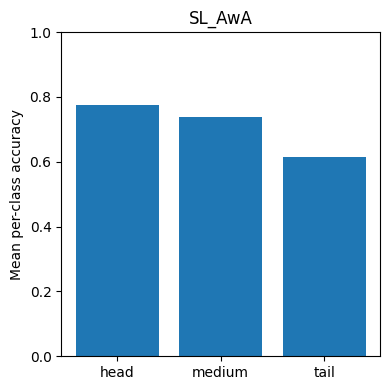

In [39]:
plot_head_tail(groups, title="SL_AwA")

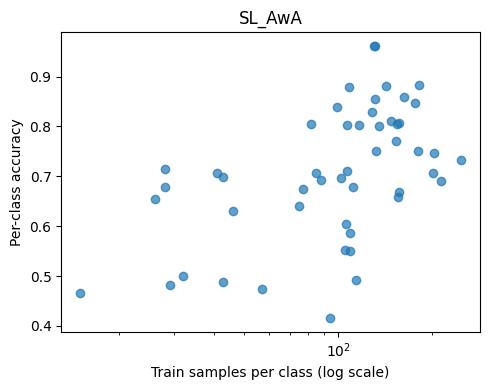

In [40]:
plot_size_vs_acc(per_class_test_counts, per_class_acc, title="SL_AwA")

In [41]:
features, labels = extract_features(model, test_loader)

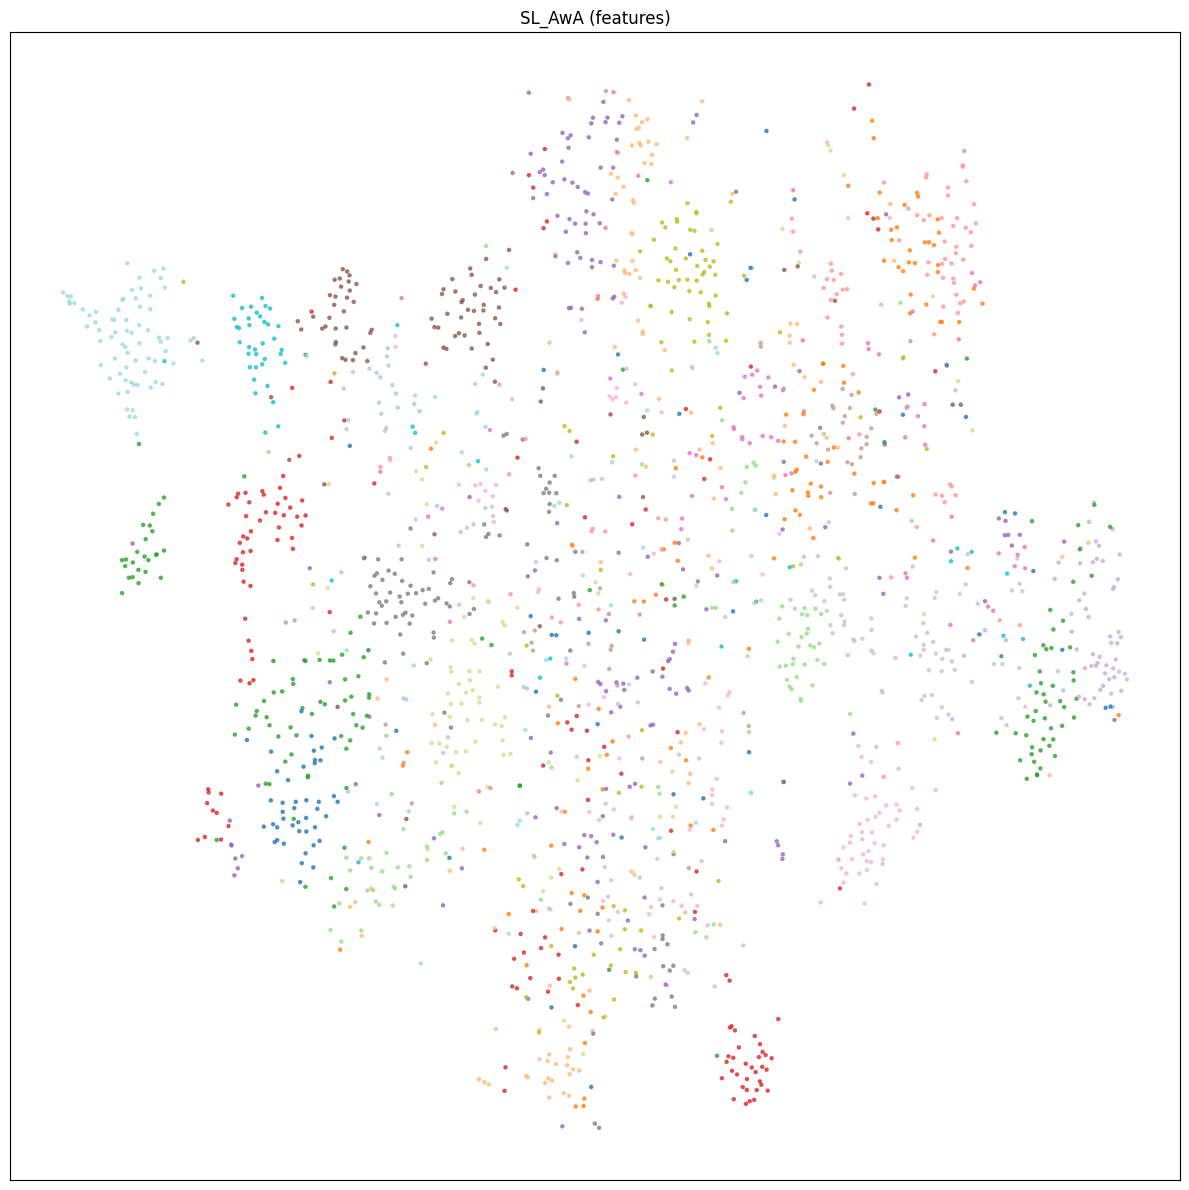

In [42]:
plot_tsne(features, labels, title="SL_AwA (features)")

In [28]:
backbone = models.resnet50(weights=None)
feature_size = backbone.fc.in_features
backbone.fc = torch.nn.Identity()

backbone = backbone.to("cuda")


ckpt = torch.load("/kaggle/input/finetune-new/checkpoint_awa_1_model_no_frozen_backbone_exp3.pth")

# state_dict = ckpt['model_state'] 

model = FinetuneModel(backbone = backbone, feature_size = 2048, num_classes = 50)

model.load_state_dict(ckpt, strict=False)

<All keys matched successfully>

In [29]:
model = model.to("cuda")

num_classes = len(base_dataset.class_names)
overall_acc, per_class_acc, per_class_test_counts = evaluate_model(
    model, test_loader, num_classes=num_classes
)
print("Test overall acc:", overall_acc)
print("Per class acc:", per_class_acc)
print("Per class test counts:", per_class_test_counts)

Test overall acc: 0.7844257903197
Per class acc: [0.84713376 0.40350877 0.31034483 0.07692308 0.71276596 0.79259259
 0.57647059 0.76146789 0.74675325 0.73134328 0.87804878 0.82673267
 0.86619718 0.91025641 0.71717172 0.64516129 0.99236641 0.98342541
 0.84732824 0.7578125  0.83760684 0.64705882 0.8097166  0.79439252
 0.60465116 0.96296296 0.87581699 0.06666667 0.66037736 0.10714286
 0.43859649 0.73394495 0.8125     0.80373832 0.98461538 0.94478528
 0.68831169 0.32608696 0.73333333 0.87837838 0.8685446  0.73333333
 0.64285714 0.51162791 0.85555556 0.93181818 0.15625    0.51219512
 0.67045455 0.98295455]
Per class test counts: [157  57  29  26  94 135  85 109 154 201  82 202 142 156  99 155 131 181
 131 128 117 102 247 107  43 108 153  15 106  28 114 109 112 107 130 163
  77  46 105 148 213  75  28  43 180 132  32  41  88 176]


In [30]:
groups = compute_head_tail_stats(per_class_test_counts, per_class_acc)

for g in ["head", "medium", "tail"]:
    print(
        g,
        "mean count:", groups[g]["mean_count"],
        "mean acc:", groups[g]["mean_acc"]
    )


head mean count: 172.6875 mean acc: 0.8478342375784165
medium mean count: 114.52941176470588 mean acc: 0.7892407019060711
tail mean count: 52.294117647058826 mean acc: 0.4692729049773912


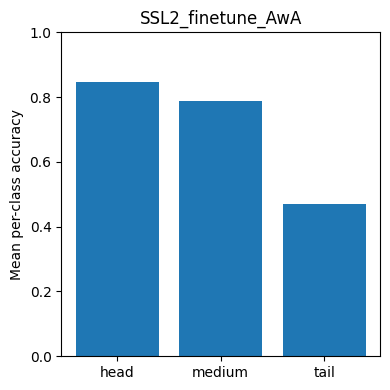

In [31]:
plot_head_tail(groups, title="SSL2_finetune_AwA")

In [32]:
features, labels = extract_features(backbone, test_loader)

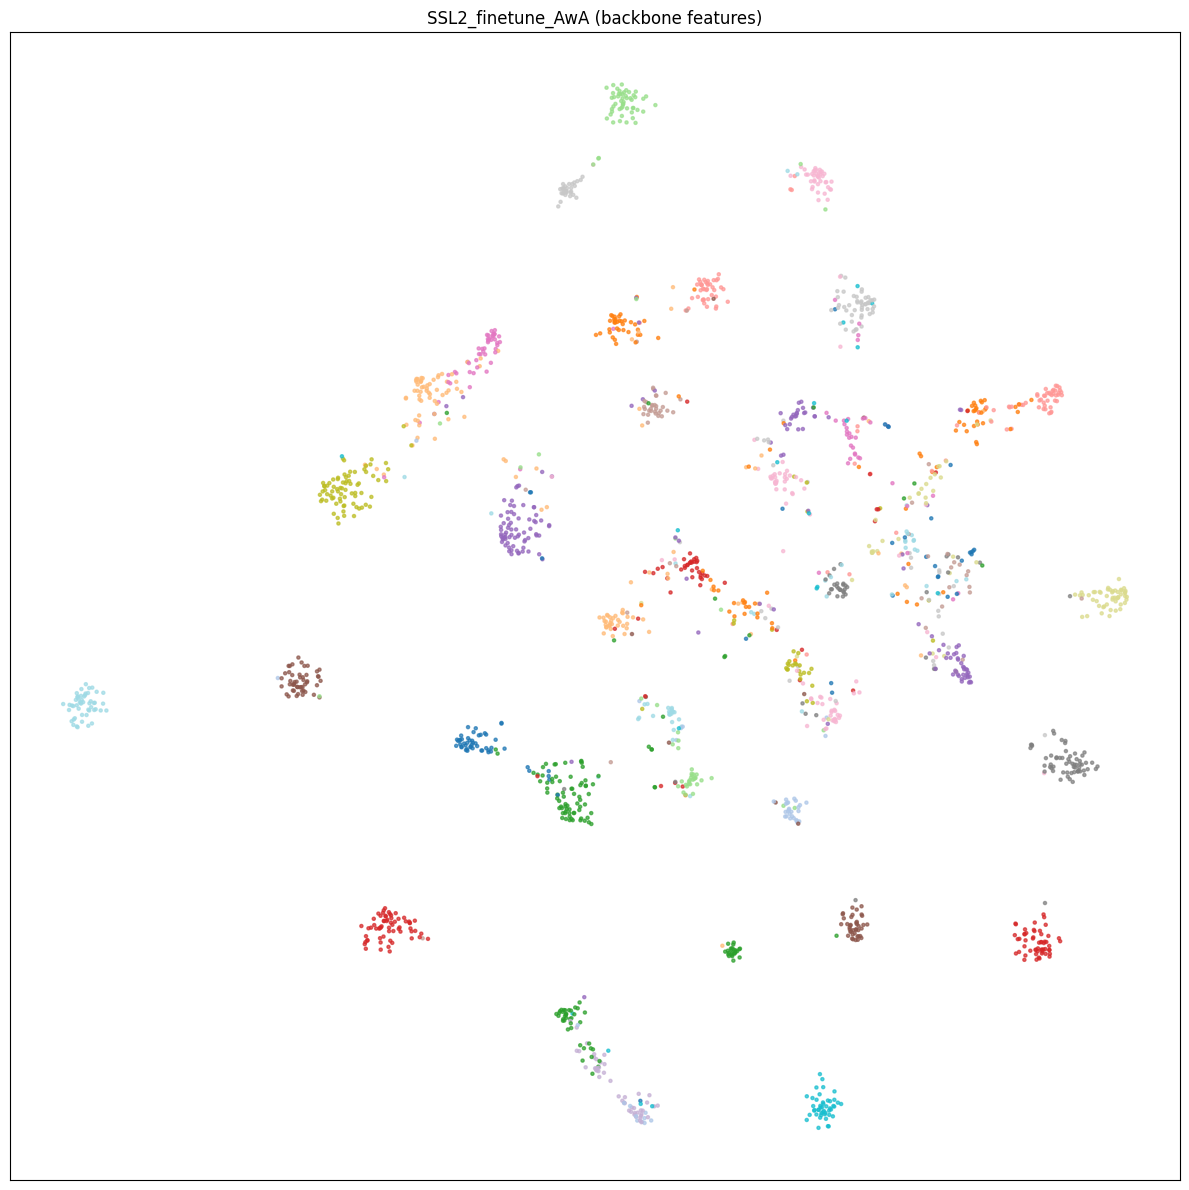

In [33]:
plot_tsne(features, labels, title="SSL2_finetune_AwA (backbone features)")

SSL backbone head/medium/tail: 0.8597982852380953 0.8221634445454544 0.8718686472727271


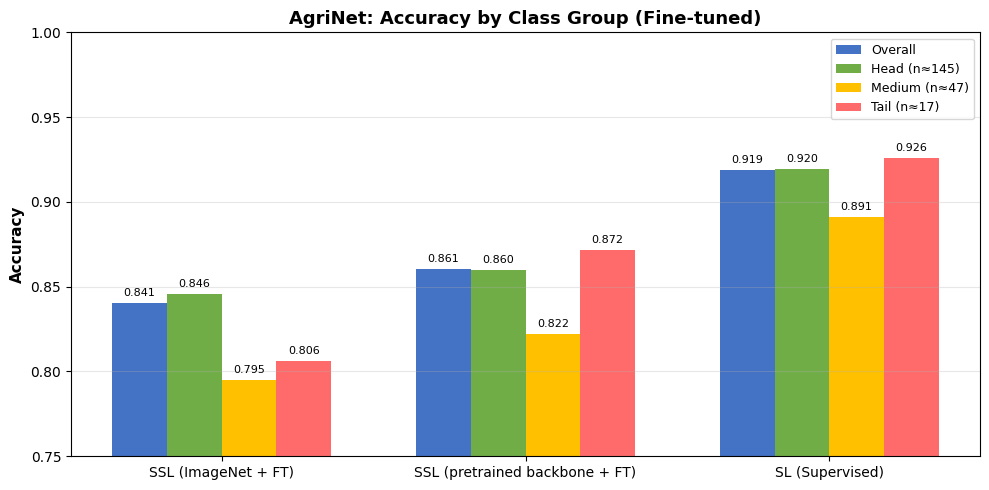

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Вставляем сюда метрики ====

# 1) SSL (ImageNet + fine-tune на AgriNet)
overall_ssl_imagenet = 0.840556927913766
head_ssl_imagenet   = 0.8457821370366904
medium_ssl_imagenet = 0.7948484432391104
tail_ssl_imagenet   = 0.8061032450869117

# 2) SL (supervised на AgriNet)
overall_sl   = 0.9189310577139007
head_sl      = 0.9196275914613078
medium_sl    = 0.8912636263423511
tail_sl      = 0.9260202837089025

# 3) SSL (pretrained backbone + fine-tune на AgriNet)
overall_ssl_backbone = 0.8605434538513361
# Для head/medium/tail берём те же группы, что и раньше:
# Используем те же индексы, что для прошлых расчётов
per_class_acc_ssl_backbone = np.array([
    1.        , 0.88888889, 0.92105263, 0.93846154, 0.60526316, 0.71223022,
    0.79166667, 0.91304348, 1.        , 1.        , 0.82608696, 0.93181818,
    0.73913043, 0.88823529, 0.55555556, 0.74910394, 0.42857143, 0.2962963 ,
    0.36363636, 0.89583333, 1.        , 0.75      , 0.90909091, 0.83333333,
    0.94117647, 0.95238095, 1.        , 0.79411765, 1.        , 0.94736842,
    0.87755102, 0.95384615, 0.70491803, 0.89130435, 1.        , 0.92741935,
    0.94444444, 1.        , 0.94845361, 0.81481481, 1.        , 0.96551724,
    0.92366412, 0.84827586, 0.80769231, 0.92920354, 0.77777778, 0.93103448,
    0.53846154, 0.85714286, 0.875      , 0.8125    , 0.96296296, 0.94117647,
    0.98755187, 0.84782609, 0.88392857, 0.95783133, 0.96428571, 0.96666667,
    0.9122807 , 0.25      , 0.90217391, 0.91479821, 0.93162393
])

per_class_train_counts = np.array([
     26,  18,  76,  65,  38, 139,  24,  23,  12,  15,  46,  44,  46, 170,
    144, 279,  49,  81,  33,  96, 111,  12,  11,  18,  17,  21,   6,  34,
     27,  57,  49,  65,  61, 138, 122, 124,  36,  55,  97,  54,  15,  29,
    131, 145,  52, 113,  36,  29,  13,  14,   8,  16,  27,  17, 241,  46,
    112, 166,  28,  30, 114,   8, 184, 223, 117
])

# Функция для head/medium/tail (та же логика, что раньше)
def compute_head_medium_tail(counts, acc, num_splits=3):
    order = np.argsort(counts)  # от tail к head
    splits = np.array_split(order, num_splits)
    groups = {}
    for name, idxs in zip(["tail", "medium", "head"], splits):
        groups[name] = float(acc[idxs].mean())
    return groups

groups_ssl_backbone = compute_head_medium_tail(per_class_train_counts, per_class_acc_ssl_backbone)
tail_ssl_backbone   = groups_ssl_backbone["tail"]
medium_ssl_backbone = groups_ssl_backbone["medium"]
head_ssl_backbone   = groups_ssl_backbone["head"]

print("SSL backbone head/medium/tail:",
      head_ssl_backbone, medium_ssl_backbone, tail_ssl_backbone)

# ==== Готовим данные для графика ====

methods = [
    "SSL (ImageNet + FT)",
    "SSL (pretrained backbone + FT)",
    "SL (Supervised)"
]

overall = [overall_ssl_imagenet, overall_ssl_backbone, overall_sl]
head   = [head_ssl_imagenet,     head_ssl_backbone,   head_sl]
medium = [medium_ssl_imagenet,   medium_ssl_backbone, medium_sl]
tail   = [tail_ssl_imagenet,     tail_ssl_backbone,   tail_sl]

x = np.arange(len(methods))
width = 0.18

fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - 1.5*width, overall, width, label="Overall", color="#4472C4")
bars2 = ax.bar(x - 0.5*width, head,    width, label="Head (n≈145)",   color="#70AD47")
bars3 = ax.bar(x + 0.5*width, medium,  width, label="Medium (n≈47)",  color="#FFC000")
bars4 = ax.bar(x + 1.5*width, tail,    width, label="Tail (n≈17)",    color="#FF6B6B")

ax.set_ylabel("Accuracy", fontsize=11, weight="bold")
ax.set_title("AgriNet: Accuracy by Class Group (Fine-tuned)", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim(0.75, 1.0)
ax.grid(axis="y", alpha=0.3)

# подписи над столбцами
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.003,
                f'{h:.3f}', ha='center', va='bottom', fontsize=8)

for b in [bars1, bars2, bars3, bars4]:
    annotate_bars(b)

plt.tight_layout()
plt.savefig("agrinet_ssl_sl_backbone_barplot.png", dpi=300, bbox_inches="tight")
plt.show()


Our SSL head/med/tail: 0.43236486875 0.29589888764705885 0.04743993529411765
SL head/med/tail: 0.7761541925 0.7383267911764706 0.6133983335294118
SSL backbone head/med/tail: 0.8478342375 0.7892407005882354 0.469272905882353


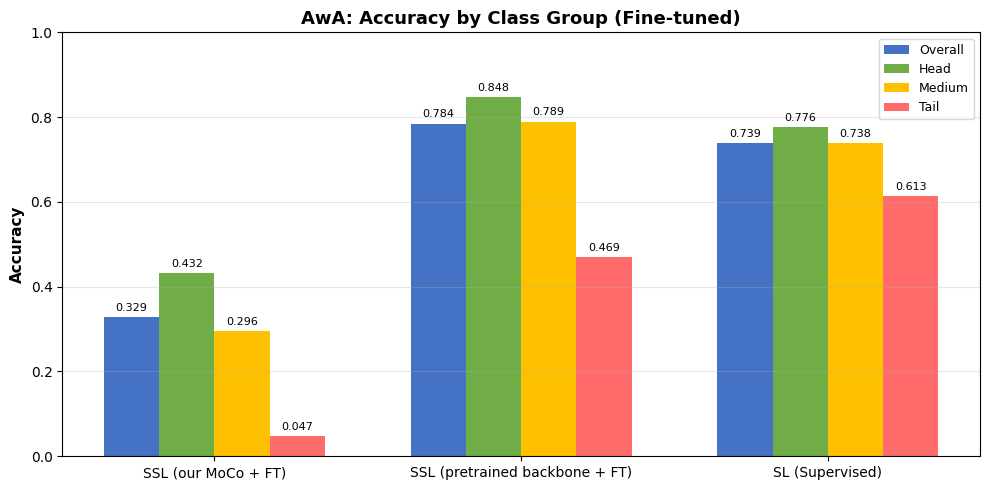

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# ==== Вставляем метрики для AwA ====

# 1) SSL (наш MoCo pretrain + fine-tune на AwA)
overall_ssl_ours = 0.3286301125200929
# для простоты возьмём среднее per-class как proxy head/medium/tail,
# либо можно пересчитать head/med/tail отдельно, если у тебя уже есть группы
per_class_acc_ssl_ours = np.array([
    0.52229299, 0.01754386, 0.        , 0.        , 0.03191489, 0.38518519,
    0.02352941, 0.01834862, 0.23376623, 0.21393035, 0.37804878, 0.24752475,
    0.76760563, 0.63461538, 0.01010101, 0.11612903, 0.67938931, 0.41436464,
    0.74045802, 0.1328125 , 0.45299145, 0.08823529, 0.38866397, 0.55140187,
    0.02325581, 0.39814815, 0.60130719, 0.        , 0.0754717 , 0.        ,
    0.02631579, 0.12844037, 0.21428571, 0.23364486, 0.63846154, 0.38650307,
    0.02597403, 0.        , 0.28571429, 0.58108108, 0.51173709, 0.22666667,
    0.        , 0.        , 0.32222222, 0.35606061, 0.        , 0.        ,
    0.07954545, 0.59090909
])
per_class_train_counts = np.array([
    157,  57,  29,  26,  94, 135,  85, 109, 154, 201,
     82, 202, 142, 156,  99, 155, 131, 181, 131, 128,
    117, 102, 247, 107,  43, 108, 153,  15, 106,  28,
    114, 109, 112, 107, 130, 163,  77,  46, 105, 148,
    213,  75,  28,  43, 180, 132,  32,  41,  88, 176
])

# 2) SL (Supervised baseline)
overall_sl = 0.7392391498481872
per_class_acc_sl = np.array([
    0.66878981, 0.47368421, 0.48275862, 0.65384615, 0.41489362, 0.8       ,
    0.70588235, 0.58715596, 0.80519481, 0.70646766, 0.80487805, 0.74752475,
    0.88028169, 0.80769231, 0.83838384, 0.65806452, 0.96183206, 0.8839779 ,
    0.85496183, 0.828125  , 0.8034188 , 0.69607843, 0.73279352, 0.80373832,
    0.69767442, 0.87962963, 0.77124183, 0.46666667, 0.60377358, 0.71428571,
    0.49122807, 0.55045872, 0.67857143, 0.71028037, 0.96153846, 0.85889571,
    0.67532468, 0.63043478, 0.55238095, 0.81081081, 0.69014085, 0.64      ,
    0.67857143, 0.48837209, 0.75      , 0.75      , 0.5       , 0.70731707,
    0.69318182, 0.84659091
])

# 3) SSL (готовый backbone + fine-tune на AwA)
overall_ssl_backbone = 0.7844257903197
per_class_acc_ssl_backbone = np.array([
    0.84713376, 0.40350877, 0.31034483, 0.07692308, 0.71276596, 0.79259259,
    0.57647059, 0.76146789, 0.74675325, 0.73134328, 0.87804878, 0.82673267,
    0.86619718, 0.91025641, 0.71717172, 0.64516129, 0.99236641, 0.98342541,
    0.84732824, 0.7578125 , 0.83760684, 0.64705882, 0.8097166 , 0.79439252,
    0.60465116, 0.96296296, 0.87581699, 0.06666667, 0.66037736, 0.10714286,
    0.43859649, 0.73394495, 0.8125    , 0.80373832, 0.98461538, 0.94478528,
    0.68831169, 0.32608696, 0.73333333, 0.87837838, 0.8685446 , 0.73333333,
    0.64285714, 0.51162791, 0.85555556, 0.93181818, 0.15625   , 0.51219512,
    0.67045455, 0.98295455
])

# ==== Функция для head/medium/tail по train-counts ====

def compute_head_medium_tail(counts, acc, num_splits=3):
    order = np.argsort(counts)  # от самых редких к самым частым
    splits = np.array_split(order, num_splits)
    groups = {}
    for name, idxs in zip(["tail", "medium", "head"], splits):
        groups[name] = float(acc[idxs].mean())
    return groups

groups_ssl_ours = compute_head_medium_tail(per_class_train_counts, per_class_acc_ssl_ours)
groups_sl       = compute_head_medium_tail(per_class_train_counts, per_class_acc_sl)
groups_ssl_bb   = compute_head_medium_tail(per_class_train_counts, per_class_acc_ssl_backbone)

head_ssl_ours   = groups_ssl_ours["head"]
medium_ssl_ours = groups_ssl_ours["medium"]
tail_ssl_ours   = groups_ssl_ours["tail"]

head_sl   = groups_sl["head"]
medium_sl = groups_sl["medium"]
tail_sl   = groups_sl["tail"]

head_ssl_bb   = groups_ssl_bb["head"]
medium_ssl_bb = groups_ssl_bb["medium"]
tail_ssl_bb   = groups_ssl_bb["tail"]

print("Our SSL head/med/tail:", head_ssl_ours, medium_ssl_ours, tail_ssl_ours)
print("SL head/med/tail:", head_sl, medium_sl, tail_sl)
print("SSL backbone head/med/tail:", head_ssl_bb, medium_ssl_bb, tail_ssl_bb)

# ==== Готовим данные для графика (вариант 2) ====

methods = [
    "SSL (our MoCo + FT)",
    "SSL (pretrained backbone + FT)",
    "SL (Supervised)"
]

overall = [overall_ssl_ours, overall_ssl_backbone, overall_sl]
head   = [head_ssl_ours,     head_ssl_bb,         head_sl]
medium = [medium_ssl_ours,   medium_ssl_bb,       medium_sl]
tail   = [tail_ssl_ours,     tail_ssl_bb,         tail_sl]

x = np.arange(len(methods))
width = 0.18

fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - 1.5*width, overall, width, label="Overall", color="#4472C4")
bars2 = ax.bar(x - 0.5*width, head,    width, label="Head",   color="#70AD47")
bars3 = ax.bar(x + 0.5*width, medium,  width, label="Medium", color="#FFC000")
bars4 = ax.bar(x + 1.5*width, tail,    width, label="Tail",   color="#FF6B6B")

ax.set_ylabel("Accuracy", fontsize=11, weight="bold")
ax.set_title("AwA: Accuracy by Class Group (Fine-tuned)", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(methods, fontsize=10)
ax.legend(fontsize=9)
ax.set_ylim(0.0, 1.0)
ax.grid(axis="y", alpha=0.3)

def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h + 0.01,
                f'{h:.3f}', ha='center', va='bottom', fontsize=8)

for b in [bars1, bars2, bars3, bars4]:
    annotate_bars(b)

plt.tight_layout()
plt.savefig("awa_ssl_sl_backbone_barplot.png", dpi=300, bbox_inches="tight")
plt.show()
